<h1> Final assignment description </h1>

The objective is to classify three different classes of ECG signals.
-<h4> Normal sinus rythm; </h4> 
![Normal sinus rythm](img/normal.PNG)
-<h4> Premature ventricular complex (PVC); </h4> 
![PAC](img/pvc.PNG)
-<h4> Premature atrial complex (PAC); </h4> 
![PVC](img/pac.PNG)


We must classify each beat of the signal and each beat of the training set is labelled with:
- N: normal sinus rythm; <br>
- S: supraventricular beats (PAC); <br>
- V: ventricular beats (PVC); <br>

<h2>Dataset </h2>

- 105 patients;
- fs: 128 or 250 Hz;
- 2 leads ECG -> 2 ecg signal for each patient; 
- Rpeaks are annotated in the dedicated .mat file;

File format: 
- [PatientID]\_[fs]+".mat" $\rightarrow$ 2 leads ECG signal;
- [PatientID]\_[fs]+\_[ann]+".mat" $\rightarrow$ labelling of the Rpeaks;
- [PatientID]\_[fs]+\_[rpk]+".mat" $\rightarrow$ Rpeaks location in the signal (at which time an Rpeak appears);

In [1]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from tqdm import tqdm
import random

SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2>Load the dataset</h2>

In [4]:
from utils.data_loading import load_data

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

print(len(rpeaks))
print(len(rpeaks[0]))

105
2851


<h2>Data visualization</h2>

In [5]:

def plot_signal(sigID,length,peakNum):

    """
    Plot first & second lead ecg signal for a fixed length, centered at indexed peak
    """
    peak = rpeaks[sigID][peakNum]
    signal = np.asarray(ecg_signals[sigID]).astype(np.float32)

    x = list()

    range_ = range(int(peak-length/2),int(peak+length/2))
    for r in range_:
        if(r >= 0):
            x.append(r)

    y_first_lead = signal[x,0]
    y_second_lead = signal[x,1]
    fig, axs = plt.subplots(2)

    axs[0].set_title(label="First and second lead")
    
    axs[0].plot(x, y_first_lead, linewidth=2.0)
    axs[1].plot(x,y_second_lead,linewidth=2.0)


    #we are plotting only the defined time, so we must count how many peaks 
    indexes = list()
    
    for i,p in enumerate(rpeaks[sigID]):
        if (p >= peak-length/2 and p <= peak + length/2):
            indexes.append(i)
    
    x = [rpeaks[sigID][i] for i in indexes]  # time values of the peaks in between the defined length 
    y_first = ecg_signals[sigID][x,0]         # amplitude value of the peaks for first lead 
    y_second = ecg_signals[sigID][x,1]
    
    axs[0].scatter(x,y_first,color = "red")
    axs[1].scatter(x,y_second,color = "red")

    peaks_labels = labels[sigID][indexes] 
    offset = 15
    for i,label in enumerate(peaks_labels):
        axs[0].annotate(label,(x[i]-offset,y_first[i]),fontsize = "large")
        axs[1].annotate(label,(x[i]-offset,y_second[i]),fontsize = "large")

    plt.show()
    

Visualize examples of beats for each class

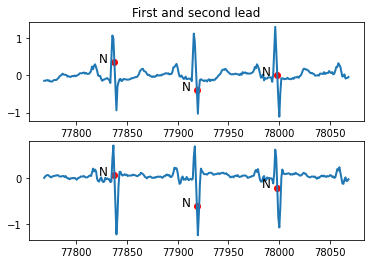

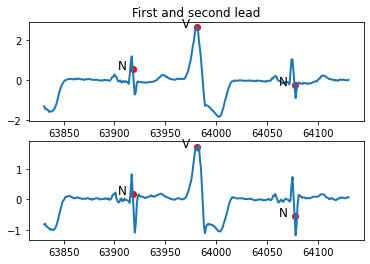

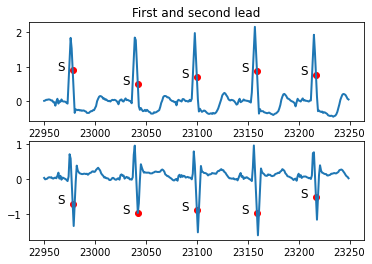

In [6]:
n_index = list()
v_index = list()
s_index = list()
sigID_N = 0
sigID_V = 0
sigID_S = 0

for i,label in enumerate(labels):
    res = np.where(label == "N")
    if (len(res) != 0):
        sigID_N = i
        n_index = res[0]
        break
for i,label in enumerate(labels):
    res = np.where(label == "V")
    if (len(res) != 0):
        sigID_V = i
        v_index = res[0] 
        break
for i,label in enumerate(labels):
    res = np.where(label == "S")
    if (len(res) != 0):
        sigID_S = i
        s_index = res[0] 
        break



plot_signal(sigID_N,300,n_index[int(len(n_index)/3)])
plot_signal(sigID_V,300,v_index[int(len(v_index)/3)])
plot_signal(sigID_S,300,s_index[int(len(s_index)/3)])

<h2> Problem: Class imbalance </h2>
This must be addressed in a proper way.

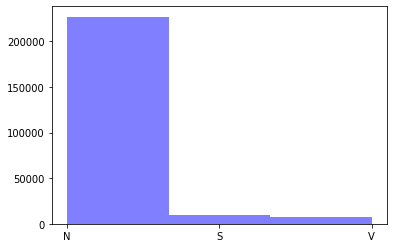

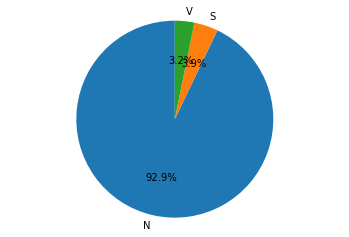

N beats samples: 226932
S beats samples: 9609
V beats samples: 7795


In [7]:
def count_classes(labels,classes):
    
    counts = [0]*len(classes)

    for i,k in enumerate(classes): # iterate over the classes is not the most efficient one, but it's more readable at the end 
        for label in labels:
            counts[i] += len(np.where(label == k)[0])

    return counts

classes = ["N","S","V"]

x = list()
counts = count_classes(labels,classes)

for i,k in enumerate(classes):
    x.extend([k]*counts[i])

num_bins = len(classes)
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

print(f"N beats samples: {counts[0]}")
print(f"S beats samples: {counts[1]}")
print(f"V beats samples: {counts[2]}")

<h2>Create dataframe</h2>
Pandas dataframe allows to manage data easily

In [8]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols
df


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
...,...,...,...,...,...,...
100,S114,"[-0.22, -0.225, -0.23, -0.22, -0.185, -0.155, ...","[-0.86, -0.905, -0.94, -0.975, -1.0, -1.025, -...","[155, 383, 611, 835, 1053, 1275, 1497, 1719, 1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S115,"[0.385, 0.35, 0.31, 0.285, 0.265, 0.25, 0.225,...","[0.515, 0.45, 0.38, 0.33, 0.3, 0.28, 0.25, 0.2...","[215, 437, 667, 823, 1119, 1349, 1589, 1737, 2...",250,"[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ..."
102,S116,"[-0.12, -0.12, -0.12, -0.125, -0.12, -0.115, -...","[-0.1, -0.105, -0.11, -0.125, -0.135, -0.13, -...","[255, 535, 817, 1093, 1377, 1657, 1935, 2215, ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S117,"[-0.045, -0.045, -0.045, -0.045, -0.045, -0.04...","[0.175, 0.185, 0.18, 0.175, 0.175, 0.175, 0.17...","[19, 295, 575, 863, 1151, 1435, 1707, 1995, 22...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


The created df contains data for all patients, this is not useful for the task we need to perform, because we need to classify single beats.

In [9]:
# dataset needs to be created because we need to classify beats and not the entire signal 

classes = np.array(["N","S","V"])

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)


dataset = dict()
length = 170    # length of each signal, centered at the considered peak
counter = 0


for l,id in enumerate(ids):
    print(f"{l}/{len(ids)}",end='\r')
    for i,peak in enumerate(rpeaks[l]):
        
        dataset[id+"_"+str(i)] = {}
        dataset[id+"_"+str(i)]["first_lead"] = list()
        dataset[id+"_"+str(i)]["second_lead"] = list()

        for s in range(int(peak-length/2),int(peak+length/2)):

            if(s < 0 or s >= len(first_lead_signals[l])):   # padding with 0
                dataset[id+"_"+str(i)]["first_lead"].append(0.) 
                dataset[id+"_"+str(i)]["second_lead"].append(0.) 
            else:
                dataset[id+"_"+str(i)]["first_lead"].append(first_lead_signals[l][s])
                dataset[id+"_"+str(i)]["second_lead"].append(first_lead_signals[l][s])

        dataset[id+"_"+str(i)]["stringLabel"] = labels[l][i]
        dataset[id+"_"+str(i)]["label"] = convert_to_one_hot(labels[l][i])
    
print("complete")

dataset_df = pd.DataFrame.from_dict(dataset,orient="index") # create the dataframe from dictionary 

dataset_df

# dataset is complete (no NaN values)

complete


,first_lead,second_lead,stringLabel,label
S001_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S001_1,"[0.825, 1.46, 2.095, 1.455, 0.815, 0.175, -0.4...","[0.825, 1.46, 2.095, 1.455, 0.815, 0.175, -0.4...",N,"[1.0, 0.0, 0.0]"
S001_2,"[1.045, 1.68, 2.05, 1.41, 0.77, 0.13, -0.39, -...","[1.045, 1.68, 2.05, 1.41, 0.77, 0.13, -0.39, -...",N,"[1.0, 0.0, 0.0]"
S001_3,"[1.125, 1.76, 1.94, 1.3, 0.66, 0.02, -0.4, -0....","[1.125, 1.76, 1.94, 1.3, 0.66, 0.02, -0.4, -0....",N,"[1.0, 0.0, 0.0]"
S001_4,"[1.25, 1.885, 1.48, 0.84, 0.2, -0.44, -0.38, -...","[1.25, 1.885, 1.48, 0.84, 0.2, -0.44, -0.38, -...",N,"[1.0, 0.0, 0.0]"
...,...,...,...,...
S118_2447,"[0.015, 0.01, 0.01, 0.005, 0.0, 0.0, 0.005, 0....","[0.015, 0.01, 0.01, 0.005, 0.0, 0.0, 0.005, 0....",N,"[1.0, 0.0, 0.0]"
S118_2448,"[-0.02, -0.025, -0.025, -0.025, -0.025, -0.025...","[-0.02, -0.025, -0.025, -0.025, -0.025, -0.025...",N,"[1.0, 0.0, 0.0]"
S118_2449,"[-0.04, -0.04, -0.045, -0.05, -0.055, -0.055, ...","[-0.04, -0.04, -0.045, -0.05, -0.055, -0.055, ...",N,"[1.0, 0.0, 0.0]"
S118_2450,"[-0.005, -0.005, -0.01, -0.015, -0.02, -0.03, ...","[-0.005, -0.005, -0.01, -0.015, -0.02, -0.03, ...",N,"[1.0, 0.0, 0.0]"


Balance classes

In [10]:
import random

validation_percentage = 0.2
# N beats samples: 226932
# S beats samples: 9609
# V beats samples: 7795

# to balance classes we may want to drop at least 216k normal beats in input

to_drop = 216000
SEED = 1234
random.seed(SEED)

ids_to_drop = list()

ids = dataset_df.index[dataset_df['stringLabel'] == 'N'].tolist() #ids where label is = 'N'
random.shuffle(ids)
ids_to_drop = ids[:to_drop]

balanced_df = dataset_df.drop(ids_to_drop)
balanced_df




,first_lead,second_lead,stringLabel,label
S001_8,"[1.07, 1.705, 1.72, 1.08, 0.44, -0.2, -0.42, -...","[1.07, 1.705, 1.72, 1.08, 0.44, -0.2, -0.42, -...",N,"[1.0, 0.0, 0.0]"
S001_17,"[0.04, 0.06, 0.05, 0.04, 0.04, -0.01, 0.0, 0.0...","[0.04, 0.06, 0.05, 0.04, 0.04, -0.01, 0.0, 0.0...",V,"[0.0, 0.0, 1.0]"
S001_19,"[-0.02, -0.05, -0.05, -0.06, -0.08, -0.08, -0....","[-0.02, -0.05, -0.05, -0.06, -0.08, -0.08, -0....",V,"[0.0, 0.0, 1.0]"
S001_21,"[0.0, -0.01, -0.03, -0.05, -0.05, -0.06, -0.01...","[0.0, -0.01, -0.03, -0.05, -0.05, -0.06, -0.01...",V,"[0.0, 0.0, 1.0]"
S001_37,"[0.29, 0.925, 1.56, 2.11, 1.47, 0.83, 0.19, -0...","[0.29, 0.925, 1.56, 2.11, 1.47, 0.83, 0.19, -0...",N,"[1.0, 0.0, 0.0]"
...,...,...,...,...
S118_2343,"[0.01, 0.0, -0.005, -0.02, -0.035, -0.035, -0....","[0.01, 0.0, -0.005, -0.02, -0.035, -0.035, -0....",N,"[1.0, 0.0, 0.0]"
S118_2394,"[0.01, 0.005, 0.005, 0.005, 0.01, 0.01, 0.0, -...","[0.01, 0.005, 0.005, 0.005, 0.01, 0.01, 0.0, -...",N,"[1.0, 0.0, 0.0]"
S118_2396,"[0.0, 0.0, 0.015, 0.015, -0.005, 0.0, 0.02, 0....","[0.0, 0.0, 0.015, 0.015, -0.005, 0.0, 0.02, 0....",N,"[1.0, 0.0, 0.0]"
S118_2440,"[0.015, 0.015, 0.02, 0.03, 0.035, 0.035, 0.025...","[0.015, 0.015, 0.02, 0.03, 0.035, 0.035, 0.025...",N,"[1.0, 0.0, 0.0]"


N: 10932
V: 7795
S: 9609


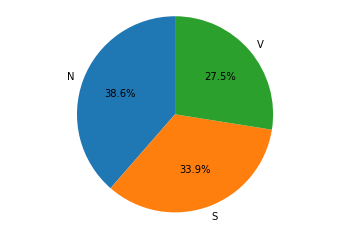

In [11]:
ids_n = balanced_df.index[balanced_df['stringLabel'] == 'N'].tolist() 
ids_v = balanced_df.index[balanced_df['stringLabel'] == 'V'].tolist() 
ids_s = balanced_df.index[balanced_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()



<h2>Split Train/Validation</h2>

In [12]:
from sklearn.model_selection import train_test_split

# Training set

train_df, validation_df = train_test_split(balanced_df, test_size=validation_percentage)


x_train_ = train_df[['first_lead','second_lead']].values

x_train = list()
for k in x_train_:
    x_train.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_train = np.asarray(x_train).astype(np.float32)

y_train = train_df['label'].values.tolist()
y_train = np.asarray(y_train).astype(np.float32)

# Validation set

x_valid_ = validation_df[['first_lead','second_lead']].values

x_valid = list()
for k in x_valid_:
    x_valid.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_valid = np.asarray(x_valid).astype(np.float32)

y_valid = validation_df['label'].values.tolist()
y_valid = np.asarray(y_valid).astype(np.float32)

print(f"samples available for training: {len(x_train)}")
print(f"samples available for validation: {len(x_valid)}")


samples available for training: 22668
samples available for validation: 5668


N: 8757
V: 6245
S: 7666


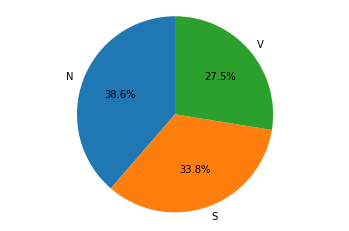

In [13]:
# count classes for training

ids_n = train_df.index[train_df['stringLabel'] == 'N'].tolist() 
ids_v = train_df.index[train_df['stringLabel'] == 'V'].tolist() 
ids_s = train_df.index[train_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

N: 2175
V: 1550
S: 1943


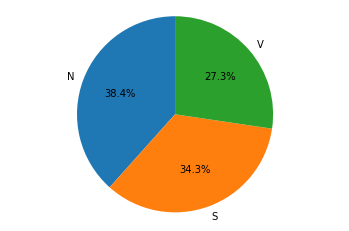

In [14]:
# count classes for validation

ids_n = validation_df.index[validation_df['stringLabel'] == 'N'].tolist() 
ids_v = validation_df.index[validation_df['stringLabel'] == 'V'].tolist() 
ids_s = validation_df.index[validation_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 340, 1)]          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 316, 64)           1664      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 158, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 147, 128)          98432     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 73, 128)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 65, 256)           2951

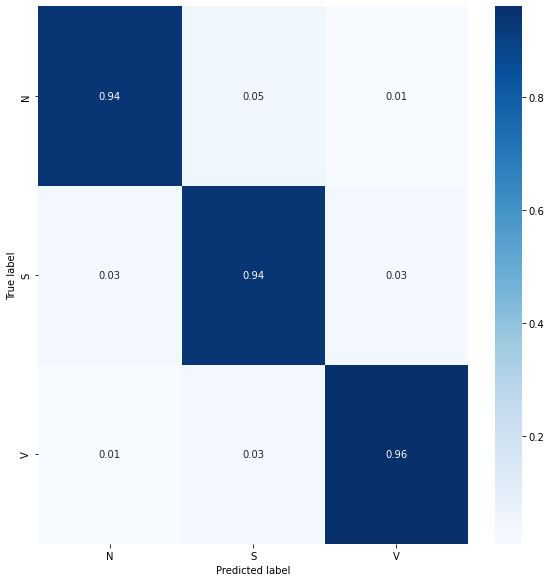

In [16]:

import seaborn as sns
from keras.utils.vis_utils import plot_model
from math import gcd

batch_size = 32

def neuralNet():
    
    input = keras.layers.Input(shape=(340,1))

    conv1 = keras.layers.Conv1D(filters=64,kernel_size=25,strides=1,padding="valid",activation="relu")(input)
    maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
    conv2 = keras.layers.Conv1D(filters=128,kernel_size=12,strides=1,padding="valid",activation="relu")(maxPool1)
    maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=9,strides=1,padding="valid",activation="relu")(maxPool2)
    maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv2)
    conv3= keras.layers.Conv1D(filters=256,kernel_size=5,strides=1,padding="valid",activation="relu")(maxPool3)
    maxPool4 = keras.layers.MaxPool1D(pool_size=2)(conv3)
    gap = keras.layers.GlobalAveragePooling1D()(maxPool4)
    
    hidden1 = keras.layers.Dense(1024, activation=tf.nn.relu,kernel_regularizer=keras.regularizers.l2(0.01),
                                 bias_regularizer=keras.regularizers.l2(0.01))(gap)
    hidden2 = keras.layers.Dense(512, activation=tf.nn.relu,kernel_regularizer=keras.regularizers.l2(0.01),
                                 bias_regularizer=keras.regularizers.l2(0.01))(hidden1)
    output = keras.layers.Dense(3, activation=tf.nn.softmax)(hidden2)
    model = keras.models.Model(inputs=input, outputs=output)
    # summarize layers
    print(model.summary())
    # plot graph
    #plot_model(model, to_file='convolutional_neural_network.png')
    return model

nn= neuralNet()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode="auto")


learning_rate = 2.5e-4
nn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    
)

history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 50,
    shuffle = True,
    callbacks=[callback],
).history

#validation_data=(X_val_filt, y_val),


def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  con_mat = tf.math.confusion_matrix(labels=y_val_classes, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
    
    


y_pred= nn.predict(x_valid)
y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_valid, axis=1)

plot_confusion_matrix(y_val_classes, y_pred)

In [19]:

eval = nn.evaluate(x=x_valid,y=y_valid,batch_size = 1)

5668/5668 [==============================] - 27s 5ms/step - loss: 0.1908 - accuracy: 0.9478


Plot history 

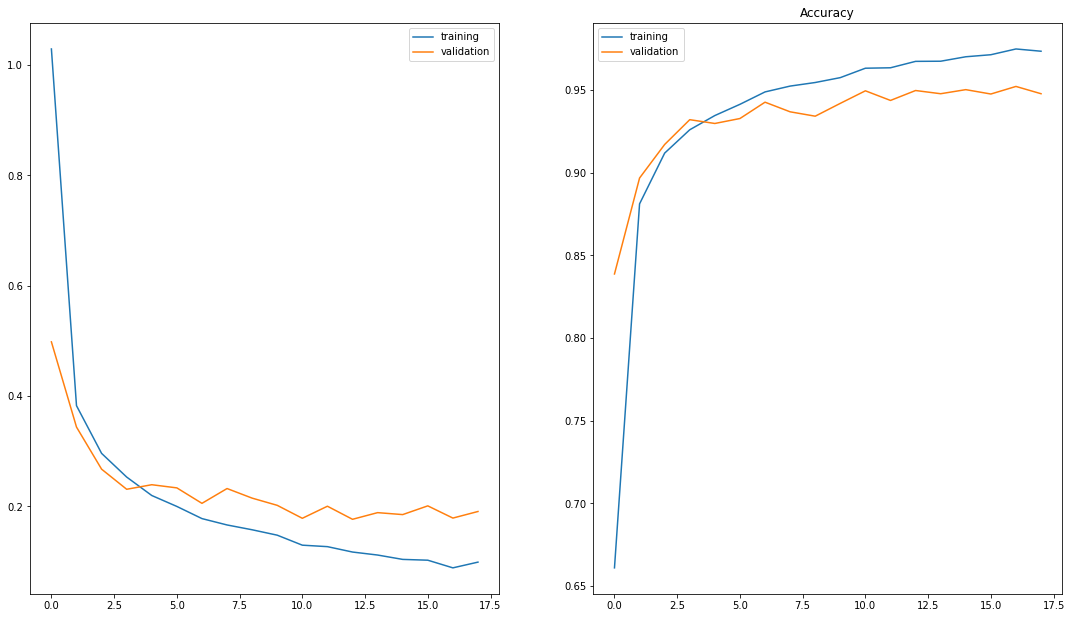

In [31]:
fig,(ax1,ax2) = plt.subplots(1,2)

x = range(len(history['loss']))
# loss
y_train = history['loss']
y_valid = history['val_loss']
ax2.set_title("Loss")
ax1.plot(x,y_train,label="training")
ax1.plot(x,y_valid,label="validation")
ax1.legend()
# accuracy 
y_train = history['accuracy']
y_valid = history['val_accuracy']
ax2.set_title("Accuracy")
ax2.plot(x,y_train,label="training")
ax2.plot(x,y_valid,label="validation")
ax2.legend()

fig.set_size_inches(18.5, 10.5)
plt.show()
